# Data Science CapStone Project- Finding the Ideal Location to open a Pizzeria in Colombo Sri Lanka

### The two objectives of this notebook are,

1. Locate clusters of suburbs of the city with venue types that attract spending (on restaurants).
2. In desirable clusters find suburbs that have low presence of casual and fast casual dining restaurants

Import necessary libraries

In [105]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import distance


import requests # library to handle requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics 
from scipy.spatial.distance import cdist


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import matplotlib.cm as cm


print('Libraries imported.')

Libraries imported.


In [2]:
def get_lat_lng(address):
    """
    This funtion is used to convert an address string to a latitude and logitude value.
    
    eg:- get_lat_lng('Toronto, Ontario')
    
    returns  43.6534817, -79.3839347
    """
    
    try:
    
        location = geolocator.geocode('{}, Colombo, Sri Lanka'.format(address))
        latitude = location.latitude
        longitude = location.longitude
            
        return latitude, longitude
    
    except:
        return None, None

In [3]:
def get_distance(lat1, lng1,lat2,lng2):
    """
    Used to get the distance between two pairs of coordinates
    """
    
    sub=(lat1,lng1)
    ven=(lat2,lng2)
    
    return distance(sub,ven).km

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    """
    For a given locality, latitude and longitude, venues within a specified radius and limit are returned
    """
    
    venues_list=[]
    LIMIT=100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
def return_most_common_venues(row, num_top_venues):
    """Used to calculate the most common N venues in a locality
    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Get html data from wikipedia

In [5]:
wiki_link='https://en.wikipedia.org/wiki/Category:Suburbs_of_Colombo'
res=requests.get(wiki_link)
if res.status_code==200:
    soup=BeautifulSoup(res.text,'html.parser')
else:
    print("Scrape Failed. Retry!\n")

In [6]:
#list to contain suburbs
suburbs=[]

In [7]:
#append suburbs onto list
for x in soup.find_all("div",class_="mw-category")[0].find_all("li"):
    suburbs.append(x.text)

In [8]:
#First item is not a suburb therefore it is dropped
suburbs=suburbs[1:]

Geo-Code Locations 

In [9]:
#A previously geocoded file of colombo suburbs is used 
colombo=pd.read_csv("Colombo.csv")

colombo=colombo[colombo.Suburb.isin(suburbs)]

Map Areas

In [10]:
#Define Colombo Latitude Longitude
latitude=6.927079
longitude=79.861244

In [11]:
# create map of Colombo using latitude and longitude values
map_colombo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(colombo['Latitude'], colombo['Longitude'], colombo['Suburb']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_colombo)  
    
map_colombo

### Use FourSquare to obtain venue details

Four Square credentials

In [40]:
CLIENT_ID = 'D401AJGJPVCSSPFFCVAOAN2ZE2RRTF2OGQDP5OOTHJEXK5NR' # your Foursquare ID
CLIENT_SECRET = 'ETW1QCU54RFBEILWBMCJ11PVGNLUWZMCUWQ5AVGVEHC220VV' # your Foursquare Secret
VERSION = '20200304'

Get venue details

In [41]:
colombo_venues = getNearbyVenues(names=colombo['Suburb'],
                                   latitudes=colombo['Latitude'],
                                   longitudes=colombo['Longitude']
                              )

Athurugiriya
Bambalapitiya
Battaramulla
Batuwatta
Bloemendhal
Boralesgamuwa
Borella
Cinnamon Gardens
Colombo
Dalugama
Dehiwala
Dehiwala-Mount Lavinia
Dematagoda
Fort (Colombo)
Grandpass
Havelock Town
Hokandara
Hulftsdorp
Ja-Ela
Kadawatha
Kaduwela, Western Province
Kahathuduwa
Kalubowila
Kandana
Kelaniya
Kiribathgoda
Kirulapana
Kohuwala
Kollupitiya
Kolonnawa
Koswatte
Kotahena
Kotikawatta
Kottawa
Madampitiya
Maha Nuge Gardens
Maharagama
Malabe
Maradana
Mattakkuliya
Modara
Moratuwa
Mount-Lavinia
Narahenpita
Nawala
Nugegoda
Pamankada
Panchikawatte
Pannipitiya
Pelawatte
Peliyagoda
Pettah, Sri Lanka
Piliyandala
Ragama
Rajagiriya
Ratmalana
Slave Island
Sri Jayawardenepura Kotte
Template:Suburbs of Colombo
Thalawathugoda
Union Place
Wattala
Welikada
Wellawatte
Wickramasinhapura


Drop duplicated venues that fall into multiple suburbs

In [42]:
colombo_venues['distance']=[get_distance(a,b,c,d) for a, b, c,d in zip(colombo_venues['Neighborhood Latitude'],colombo_venues['Neighborhood Longitude'],
                                           colombo_venues['Venue Latitude'],colombo_venues['Neighborhood Longitude'])] 
 

In [43]:
#sort values by venue and distance
colombo_venues.sort_values(by=['Venue','Venue Latitude','Venue Longitude','distance'],inplace=True)

#drop duplicated values keeping first to ensure shortest distance
colombo_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'],keep='first',inplace=True)

### Analyze Neighborhoods

In [44]:
#one hot encoding venue categories and adding back neighborhod
colombo_onehot=pd.get_dummies(colombo_venues[['Venue Category']], prefix="", prefix_sep="")
colombo_onehot["Neighborhood"]=colombo_venues.Neighborhood

In [60]:
#group venue category by neighborhood and get mean
colombo_grouped = colombo_onehot.groupby('Neighborhood').mean().reset_index()

Find top venue types in each suburbs

In [74]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = colombo_grouped['Neighborhood']

for ind in np.arange(colombo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(colombo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Athurugiriya,Intersection,Juice Bar,Bus Stop,Zoo,Fair
1,Bambalapitiya,Hotel,Coffee Shop,Chinese Restaurant,Café,Dessert Shop
2,Battaramulla,Bakery,Electronics Store,Food & Drink Shop,Supermarket,Fast Food Restaurant
3,Batuwatta,Train Station,Zoo,English Restaurant,Food,Fondue Restaurant
4,Bloemendhal,Playground,Zoo,English Restaurant,Food,Fondue Restaurant
5,Boralesgamuwa,Athletics & Sports,Pizza Place,Track,Shopping Mall,Fast Food Restaurant
6,Borella,Clothing Store,Cosmetics Shop,Café,Convenience Store,Bakery
7,Cinnamon Gardens,Café,Restaurant,Coffee Shop,Spa,Art Gallery
8,Colombo,Bookstore,Food Truck,Cosmetics Shop,Clothing Store,Eastern European Restaurant
9,Dalugama,Bakery,Convenience Store,Juice Bar,Chinese Restaurant,Electronics Store


### Calculate optimum number of clusters for K- means

In [108]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(np.array(colombo_grouped.drop('Neighborhood', 1))) 
    kmeanModel.fit(np.array(colombo_grouped.drop('Neighborhood', 1)))     
      
    distortions.append(sum(np.min(cdist(np.array(colombo_grouped.drop('Neighborhood', 1)), kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / np.array(colombo_grouped.drop('Neighborhood', 1)).shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(np.array(colombo_grouped.drop('Neighborhood', 1)), kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / np.array(colombo_grouped.drop('Neighborhood', 1)).shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

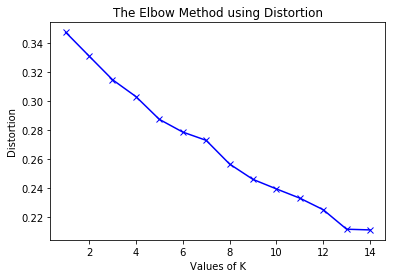

In [109]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

There is no clear elbow here therefore we look at the silhoutte score

In [111]:
sillhouette=[]
no_clusters=[]
for n_clusters in range(2,15):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(np.array(colombo_grouped.drop('Neighborhood', 1)))
    centers = clusterer.cluster_centers_

    score = silhouette_score(np.array(colombo_grouped.drop('Neighborhood', 1)), preds)
    sillhouette.append(score)
    no_clusters.append(n_clusters)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5336153800805619)
For n_clusters = 3, silhouette score is 0.5344445655551132)
For n_clusters = 4, silhouette score is 0.08557281234147182)
For n_clusters = 5, silhouette score is 0.4017593554129727)
For n_clusters = 6, silhouette score is 0.2217490918301053)
For n_clusters = 7, silhouette score is 0.28790045932725755)
For n_clusters = 8, silhouette score is 0.13246036093887167)
For n_clusters = 9, silhouette score is 0.06892766699559218)
For n_clusters = 10, silhouette score is 0.10092392275243364)
For n_clusters = 11, silhouette score is 0.05527416345461119)
For n_clusters = 12, silhouette score is 0.02965176505984118)
For n_clusters = 13, silhouette score is 0.05402506126069109)
For n_clusters = 14, silhouette score is 0.033749708393852274)


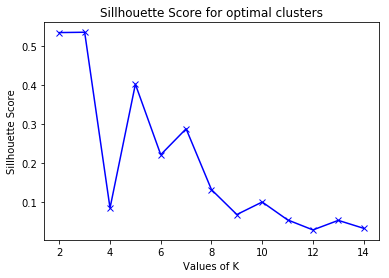

In [112]:
plt.plot(no_clusters, sillhouette, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Sillhouette Score') 
plt.title('Sillhouette Score for optimal clusters') 
plt.show() 

Since the elbow seems to go down smoothly and Sillhouette score is significantly high at 3 we pick the optimum number of clusters to be 3

#### Run K- Means for the desired number of clusters

In [116]:
# set number of clusters
kclusters = 13

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(colombo_grouped.drop('Neighborhood', 1))

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 3,  3, 11,  2,  5, 11,  3,  3,  3, 11])

Concatenate labels and geo data

In [117]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
colombo_merged = colombo_grouped[["Neighborhood"]].copy()
#Add cluster labels
colombo_merged["Cluster Labels"]=kmeans.labels_
#Assign geo data
colombo_merged=colombo_merged.merge(colombo_venues[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']],on='Neighborhood',how='left').drop_duplicates()

No of neighborhoods by cluster

In [118]:
colombo_merged['Cluster Labels'].value_counts()

3     24
11    22
10     4
1      3
12     1
9      1
8      1
7      1
6      1
5      1
4      1
2      1
0      1
Name: Cluster Labels, dtype: int64